<a href="https://colab.research.google.com/github/Xiaojia-Yu/R-for-Breast-Cancer-in-Women-in-Ohio/blob/main/cancerohio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [318]:
##0. setup

install.packages(c("tidyverse","readxl","ggthemes","maps","mapdata","stringr","ggmap"))

library(tidyverse)
library(readxl)
library(ggthemes)
library(maps)
library(mapdata)
library(stringr)
library(ggmap)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [319]:
## 1. Read & clean data

county_df <- read_excel("County data.xlsx", skip = 4) |>
  dplyr::rename(
    county      = `County`,
    rural_urban = `Rural/Urban`,
    app_flag    = `...3`          # third column (Appalachian info)
  ) |>
  dplyr::filter(!is.na(county)) |>
  dplyr::mutate(
    county = stringr::str_trim(county),
    rural_urban = factor(
      rural_urban,
      levels = c("Urban", "Partially Rural County", "Rural")
    ),
    # app_flag column is "Appalachian County" or NA
    app_flag = if_else(
      is.na(app_flag),
      "Non-Appalachian",
      "Appalachian"
    ),
    app_flag = factor(app_flag, levels = c("Non-Appalachian","Appalachian"))
  )

glimpse(county_df)

New names:
• `` -> `...3`


Rows: 88
Columns: 3
$ county      <chr> "Adams County", "Allen County", "Ashland County", "Ashtabu…
$ rural_urban <fct> Rural, Partially Rural County, Rural, Rural, Rural, Rural,…
$ app_flag    <fct> Appalachian, Non-Appalachian, Non-Appalachian, Appalachian…


In [320]:
## 2.

ru_summary <- county_df |>
dplyr::count(rural_urban) |>
dplyr::mutate(pct = round(100 * n / sum(n), 1))
ru_summary

app_summary <- county_df |>
dplyr::count(app_flag) |>
dplyr::mutate(pct = round(100 * n / sum(n), 1))
app_summary

cross_tab <- county_df |>
dplyr::count(app_flag, rural_urban) |>
dplyr::group_by(app_flag) |>
dplyr::mutate(pct_within_app = round(100 * n / sum(n), 1))
cross_tab

rural_urban,n,pct
<fct>,<int>,<dbl>
Urban,18,20.5
Partially Rural County,20,22.7
Rural,50,56.8


app_flag,n,pct
<fct>,<int>,<dbl>
Non-Appalachian,56,63.6
Appalachian,32,36.4


app_flag,rural_urban,n,pct_within_app
<fct>,<fct>,<int>,<dbl>
Non-Appalachian,Urban,15,26.8
Non-Appalachian,Partially Rural County,13,23.2
Non-Appalachian,Rural,28,50.0
Appalachian,Urban,3,9.4
Appalachian,Partially Rural County,7,21.9
Appalachian,Rural,22,68.8


In [321]:
## 3. Read other sheets & merge

# Each sheet: first column = County, second column = the variable we want.
# We use select(1, 2) so it doesn't matter what the original header text is.

income_df <- read_excel("County data.xlsx", sheet = "Income", skip = 4) %>%
  select(1, 3) %>%
  setNames(c("county", "median_income")) %>%
  mutate(
    county = county %>%
      stringr::str_to_lower() %>%
      stringr::str_remove(" county$") %>%
      stringr::str_trim(),
    median_income = as.numeric(median_income)
  )

education_df <- read_excel("County data.xlsx", sheet = "Education", skip = 4) %>%
  select(1, 3) %>%
  setNames(c("county", "college_plus_pct")) %>%
  mutate(
    county = county %>%
      stringr::str_to_lower() %>%
      stringr::str_remove(" county$") %>%
      stringr::str_trim(),
    college_plus_pct = as.numeric(college_plus_pct)
  )

population_df <- read_excel("County data.xlsx", sheet = "Population", skip = 4) %>%
  select(1, 3) %>%
  setNames(c("county", "female_pop")) %>%
  mutate(
    county = county %>%
      stringr::str_to_lower() %>%
      stringr::str_remove(" county$") %>%
      stringr::str_trim(),
    female_pop = as.numeric(female_pop)
  )

rural_urban_df <- county_df %>%
  mutate(
    county = county %>%
      stringr::str_to_lower() %>%
      stringr::str_remove(" county$") %>%
      stringr::str_trim()
  ) %>%
  select(county, rural_urban, app_flag)

map_df <- ohio_map %>%
  left_join(poverty,        by = "county") %>%
  left_join(income_df,      by = "county") %>%
  left_join(education_df,   by = "county") %>%
  left_join(population_df,  by = "county") %>%
  left_join(rural_urban_df, by = "county") %>%
  arrange(order)

dplyr::glimpse(map_df)
summary(is.na(map_df[, c("poverty_pct","median_income","college_plus_pct",
                         "female_pop","rural_urban","app_flag")]))

New names:
• `County` -> `County...1`
• `FIPS` -> `FIPS...2`
• `Value (Percent)` -> `Value (Percent)...3`
• `People (Age 65 And Over)` -> `People (Age 65 And Over)...4`
• `Rank within US (of 3143 counties)` -> `Rank within US (of 3143
  counties)...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `County` -> `County...12`
• `FIPS` -> `FIPS...13`
• `Value (Percent)` -> `Value (Percent)...14`
• `People (Age 65 And Over)` -> `People (Age 65 And Over)...15`
• `Rank within US (of 3143 counties)` -> `Rank within US (of 3143
  counties)...16`


Rows: 1,427
Columns: 13
$ long             <dbl> -83.66902, -83.56590, -83.37109, -83.30806, -83.30233…
$ lat              <dbl> 39.02989, 39.02989, 39.06426, 39.06426, 39.05280, 39.…
$ group            <dbl> 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012,…
$ order            <int> 59960, 59961, 59962, 59963, 59964, 59965, 59966, 5996…
$ region           <chr> "ohio", "ohio", "ohio", "ohio", "ohio", "ohio", "ohio…
$ subregion        <chr> "adams", "adams", "adams", "adams", "adams", "adams",…
$ county           <chr> "adams", "adams", "adams", "adams", "adams", "adams",…
$ poverty_pct      <dbl> 14.8, 14.8, 14.8, 14.8, 14.8, 14.8, 14.8, 14.8, 14.8,…
$ median_income    <dbl> 65452, 65452, 65452, 65452, 65452, 65452, 65452, 6545…
$ college_plus_pct <dbl> 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0…
$ female_pop       <dbl> 19.3, 19.3, 19.3, 19.3, 19.3, 19.3, 19.3, 19.3, 19.3,…
$ rural_urban      <fct> Rural, Rural, Rural, Rural, Rural, Rural, Rural, Rura…
$ app_flag      

 poverty_pct     median_income   college_plus_pct female_pop     
 Mode :logical   Mode :logical   Mode :logical    Mode :logical  
 FALSE:1427      FALSE:1427      FALSE:1427       FALSE:1427     
 rural_urban      app_flag      
 Mode :logical   Mode :logical  
 FALSE:1427      FALSE:1427     

In [322]:
## 4. Clean numeric variables and summarize

full_df <- full_df %>%
  mutate(
    poverty_rate     = as.numeric(poverty_rate),
    median_income    = as.numeric(gsub(",", "", median_income)),
    college_plus_pct = as.numeric(college_plus_pct),
    female_pop       = as.numeric(gsub(",", "", female_pop)),
    cancer_incidence = as.numeric(cancer_incidence)
  )

# After conversion, now summarize correctly
summary(full_df[, c("poverty_rate", "median_income", "college_plus_pct",
                    "female_pop", "cancer_incidence")])


  poverty_rate    median_income    college_plus_pct   female_pop   
 Min.   : 3.400   Min.   : 60552   Min.   : 0.900   Min.   :13.50  
 1st Qu.: 6.600   1st Qu.: 74719   1st Qu.: 1.675   1st Qu.:19.57  
 Median : 9.050   Median : 81942   Median : 2.350   Median :20.50  
 Mean   : 8.957   Mean   : 85254   Mean   : 2.989   Mean   :20.60  
 3rd Qu.:10.875   3rd Qu.: 92712   3rd Qu.: 3.125   3rd Qu.:21.75  
 Max.   :17.600   Max.   :153705   Max.   :36.200   Max.   :27.90  
 cancer_incidence
 Min.   : 83.3   
 1st Qu.:114.8   
 Median :122.8   
 Mean   :122.4   
 3rd Qu.:134.4   
 Max.   :147.8   

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


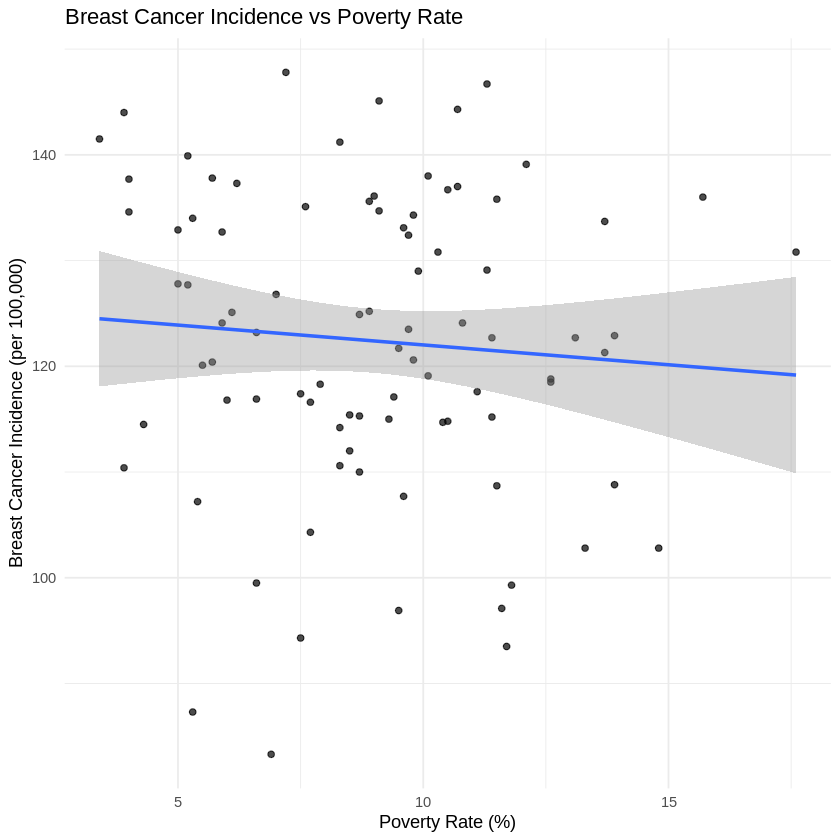

`geom_smooth()` using formula = 'y ~ x'


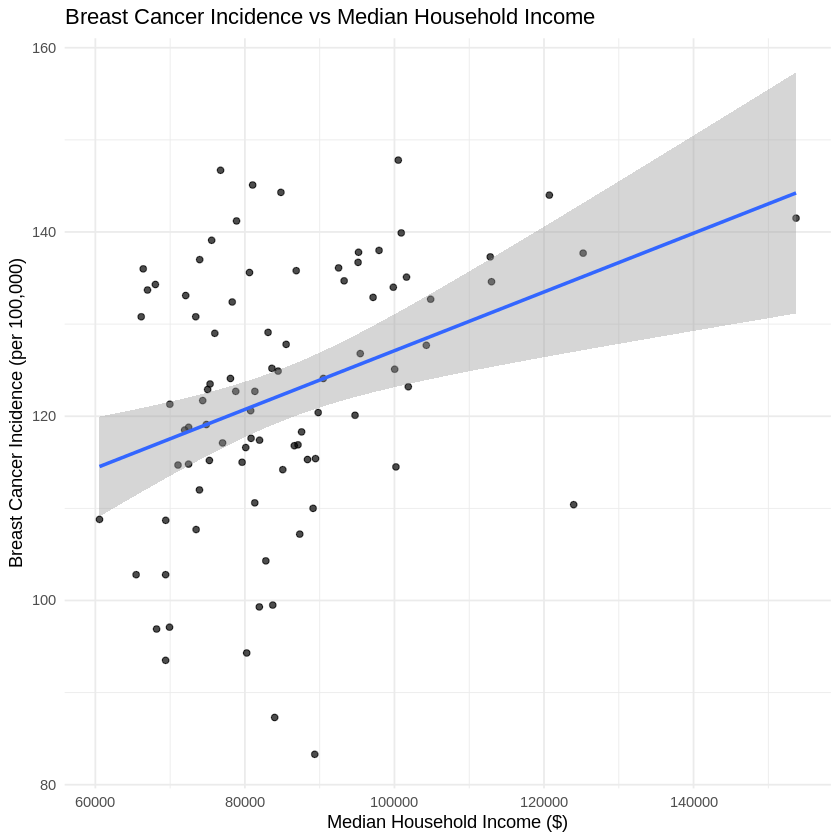

`geom_smooth()` using formula = 'y ~ x'


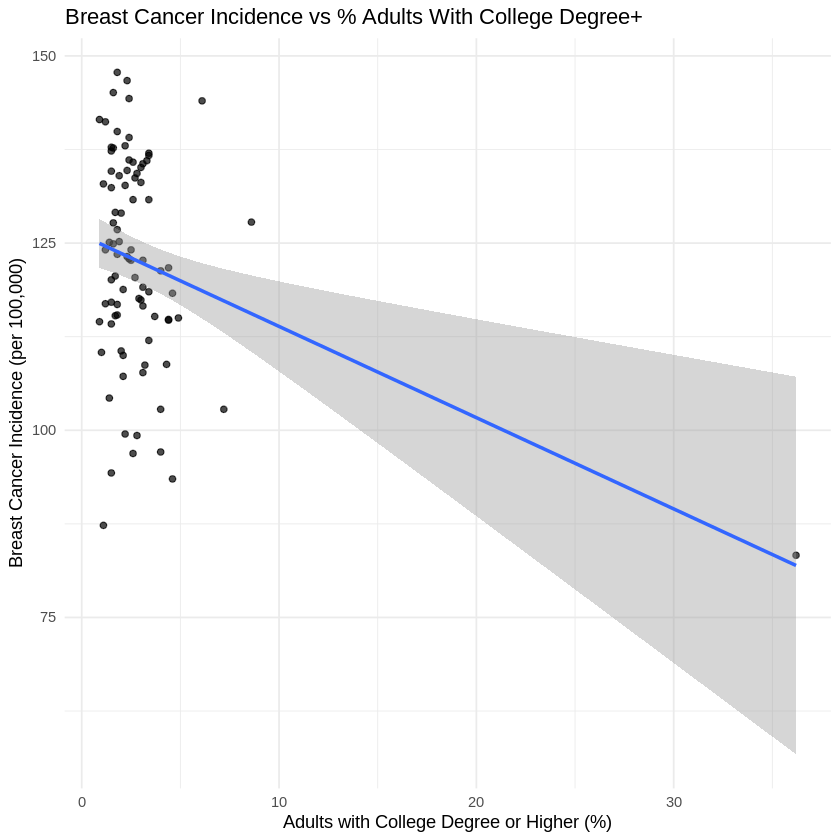

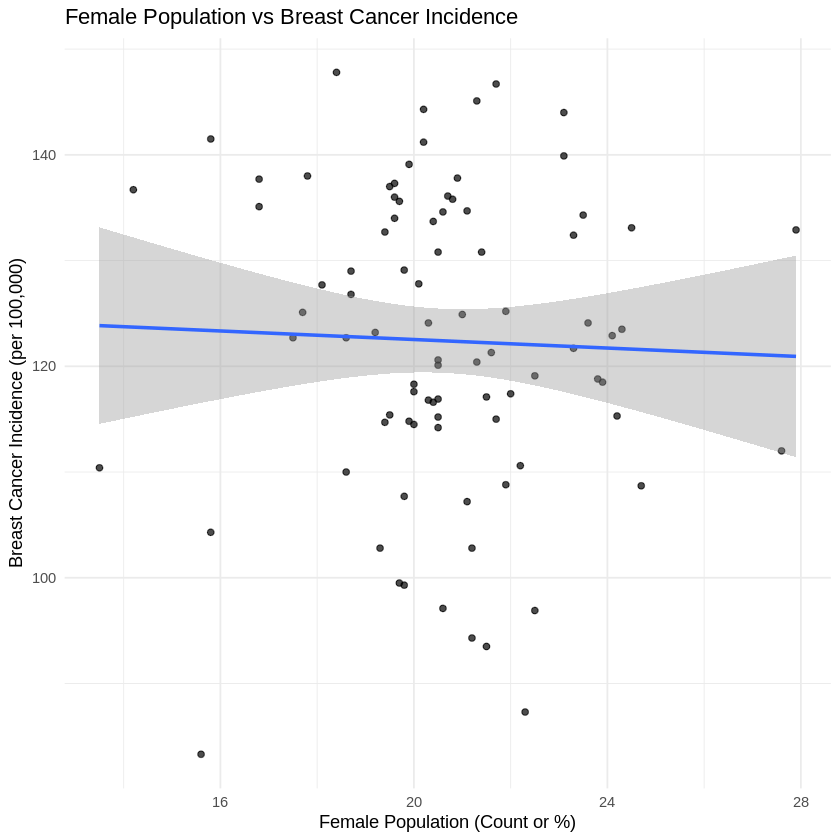

In [323]:
## 5. Graphs: Cancer incidence vs predictors

### 5.1 Poverty Rate vs Cancer Incidence

ggplot(full_df, aes(x = poverty_rate, y = cancer_incidence)) +
geom_point(alpha = 0.7) +
geom_smooth(method = "lm", se = TRUE, linewidth = 1) +
labs(
title = "Breast Cancer Incidence vs Poverty Rate",
x = "Poverty Rate (%)",
y = "Breast Cancer Incidence (per 100,000)"
) +
theme_minimal()

### 5.2 Median Household Income vs Cancer Incidence

ggplot(full_df, aes(x = median_income, y = cancer_incidence)) +
geom_point(alpha = 0.7) +
geom_smooth(method = "lm", se = TRUE, linewidth = 1) +
labs(
title = "Breast Cancer Incidence vs Median Household Income",
x = "Median Household Income ($)",
y = "Breast Cancer Incidence (per 100,000)"
) +
theme_minimal()

### 5.3 Educational Attainment (College+) vs Cancer Incidence

ggplot(full_df, aes(x = college_plus_pct, y = cancer_incidence)) +
geom_point(alpha = 0.7) +
geom_smooth(method = "lm", se = TRUE, linewidth = 1) +
labs(
title = "Breast Cancer Incidence vs % Adults With College Degree+",
x = "Adults with College Degree or Higher (%)",
y = "Breast Cancer Incidence (per 100,000)"
) +
theme_minimal()

### 5.4 Female Population (65+ or Total Female Population) vs Cancer Incidence

ggplot(full_df, aes(x = female_pop, y = cancer_incidence)) +
geom_point(alpha = 0.7) +
geom_smooth(method = "lm", se = TRUE, linewidth = 1) +
labs(
title = "Female Population vs Breast Cancer Incidence",
x = "Female Population (Count or %)",
y = "Breast Cancer Incidence (per 100,000)"
) +
theme_minimal()

In [324]:
#all data
summary(full_df)

    county                          rural_urban            app_flag 
 Length:88          Urban                 :18   Non-Appalachian:56  
 Class :character   Partially Rural County:20   Appalachian    :32  
 Mode  :character   Rural                 :50                       
                                                                    
                                                                    
                                                                    
  poverty_rate    median_income    college_plus_pct   female_pop   
 Min.   : 3.400   Min.   : 60552   Min.   : 0.900   Min.   :13.50  
 1st Qu.: 6.600   1st Qu.: 74719   1st Qu.: 1.675   1st Qu.:19.57  
 Median : 9.050   Median : 81942   Median : 2.350   Median :20.50  
 Mean   : 8.957   Mean   : 85254   Mean   : 2.989   Mean   :20.60  
 3rd Qu.:10.875   3rd Qu.: 92712   3rd Qu.: 3.125   3rd Qu.:21.75  
 Max.   :17.600   Max.   :153705   Max.   :36.200   Max.   :27.90  
 cancer_incidence high_incidence
 Min.   

In [325]:
## 6. Create "High Incidence" Binary Variable

# Median cancer incidence across all counties

median_inc <- median(full_df$cancer_incidence, na.rm = TRUE)

full_df <- full_df %>%
mutate(
high_incidence = if_else(cancer_incidence > median_inc, 1L, 0L),
high_incidence = factor(high_incidence, levels = c(0, 1),
labels = c("Low", "High"))
)

# Check distribution

table(full_df$high_incidence)



 Low High 
  44   44 

In [326]:
## 7. Simple Logistic Regression (Unadjusted)

model1 <- glm(
high_incidence ~ poverty_rate,
data = full_df,
family = binomial(link = "logit")
)

summary(model1)

## Odds ratios (Exponentiated Coefficients)

exp(coef(model1))

## 95% Confidence Intervals for ORs

exp(confint(model1))


Call:
glm(formula = high_incidence ~ poverty_rate, family = binomial(link = "logit"), 
    data = full_df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)   0.65144    0.68620   0.949    0.342
poverty_rate -0.07276    0.07285  -0.999    0.318

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 121.99  on 87  degrees of freedom
Residual deviance: 120.98  on 86  degrees of freedom
AIC: 124.98

Number of Fisher Scoring iterations: 4


(Intercept) poverty_rate 
   1.9183003    0.9298281

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),0.5057953,7.631450
poverty_rate,0.8027286,1.070943


In [327]:
# full-data
full_df %>%
  select(county, poverty_rate, median_income, college_plus_pct, female_pop) %>%
  head(10)


county,poverty_rate,median_income,college_plus_pct,female_pop
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Adams County,14.8,65452,4.0,19.3
Allen County,9.8,80766,1.7,20.5
Ashland County,7.5,81955,3.0,22.0
Ashtabula County,13.7,69960,4.0,21.6
Athens County,7.7,82794,1.4,15.8
Auglaize County,5.5,94728,1.5,20.5
Belmont County,9.7,75342,1.8,24.3
Brown County,11.8,81930,2.8,19.8
Butler County,7.6,101612,3.0,16.8


In [328]:
# Correration
cor(full_df[, c("poverty_rate", "median_income", "college_plus_pct", "female_pop")],
    use = "complete.obs")


,poverty_rate,median_income,college_plus_pct,female_pop
poverty_rate,1.00000000,-0.7680129,0.05347421,0.178908
median_income,-0.76801290,1.0000000,-0.10066532,-0.434399
college_plus_pct,0.05347421,-0.1006653,1.00000000,-0.163258
female_pop,0.17890798,-0.4343990,-0.16325804,1.000000


In [329]:
## 8. Multivariable Logistic Regression Model

model_full <- glm(
high_incidence ~ poverty_rate +
median_income +
college_plus_pct +
female_pop +
rural_urban +
app_flag,
data = full_df,
family = binomial(link = "logit")
)

summary(model_full)

## Odds ratios for the full model

exp(coef(model_full))

## 95% CI for the ORs

exp(confint(model_full))


Call:
glm(formula = high_incidence ~ poverty_rate + median_income + 
    college_plus_pct + female_pop + rural_urban + app_flag, family = binomial(link = "logit"), 
    data = full_df)

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)  
(Intercept)                       -1.564e+01  7.045e+00  -2.220   0.0264 *
poverty_rate                       3.604e-01  1.712e-01   2.105   0.0353 *
median_income                      1.131e-04  4.497e-05   2.516   0.0119 *
college_plus_pct                  -1.325e-01  2.214e-01  -0.598   0.5497  
female_pop                         1.773e-01  1.303e-01   1.360   0.1737  
rural_urbanPartially Rural County -2.005e-01  8.079e-01  -0.248   0.8040  
rural_urbanRural                  -5.397e-01  7.838e-01  -0.689   0.4911  
app_flagAppalachian               -3.126e-01  6.944e-01  -0.450   0.6525  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

(Intercept)                      poverty_rate 
                     1.617174e-07                      1.433844e+00 
                    median_income                  college_plus_pct 
                     1.000113e+00                      8.759421e-01 
                       female_pop rural_urbanPartially Rural County 
                     1.194010e+00                      8.183288e-01 
                 rural_urbanRural               app_flagAppalachian 
                     5.829222e-01                      7.315063e-01

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),3.861437e-14,0.05645994
poverty_rate,1.038560e+00,2.05234977
median_income,1.000032e+00,1.00020971
college_plus_pct,5.354245e-01,1.10210915
female_pop,9.367588e-01,1.57646366
rural_urbanPartially Rural County,1.593861e-01,4.01594039
rural_urbanRural,1.167836e-01,2.65924668
app_flagAppalachian,1.840461e-01,2.87894861


In [330]:
## 10. Load Ohio county polygons

ohio_map <- map_data("county") %>%
dplyr::filter(region == "ohio") %>%
dplyr::mutate(county = tolower(subregion))

In [331]:
## 11. Load Poverty data from County data.xlsx
## (sheet named exactly "Poverty"; header row is 4, so skip = 4)

poverty <- read_excel(
  "County data.xlsx",
  sheet = "Poverty",
  skip = 4   # THIS is the correct skip
) %>%
  transmute(
    county = stringr::str_to_lower(stringr::str_remove(County, " County$")),
    poverty_pct = as.numeric(`Value (Percent)`)
  )

# quick checks (printed in knitted doc)
head(poverty)
head(ohio_map)

county,poverty_pct
<chr>,<dbl>
adams,14.8
allen,9.8
ashland,7.5
ashtabula,13.7
athens,7.7
auglaize,5.5


,long,lat,group,order,region,subregion,county
,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
1,-83.66902,39.02989,2012,59960,ohio,adams,adams
2,-83.56590,39.02989,2012,59961,ohio,adams,adams
3,-83.37109,39.06426,2012,59962,ohio,adams,adams
4,-83.30806,39.06426,2012,59963,ohio,adams,adams
5,-83.30233,39.05280,2012,59964,ohio,adams,adams
6,-83.25649,39.01842,2012,59965,ohio,adams,adams


In [332]:
## 12. Merge map polygons with poverty data

rural_urban_df <- county_df %>%
  mutate(
    county = county %>%
      stringr::str_to_lower() %>%
      stringr::str_remove(" county$") %>%
      stringr::str_trim()
  ) %>%
  dplyr::select(county, rural_urban, app_flag)

map_df <- ohio_map %>%
  dplyr::left_join(poverty,    by = "county") %>%
  dplyr::left_join(income_df,     by = "county") %>%
  dplyr::left_join(education_df,  by = "county") %>%
  dplyr::left_join(population_df, by = "county") %>%
  dplyr::left_join(rural_urban_df, by = "county") %>%
  dplyr::arrange(order)

dplyr::glimpse(map_df)

Rows: 1,427
Columns: 13
$ long             <dbl> -83.66902, -83.56590, -83.37109, -83.30806, -83.30233…
$ lat              <dbl> 39.02989, 39.02989, 39.06426, 39.06426, 39.05280, 39.…
$ group            <dbl> 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012,…
$ order            <int> 59960, 59961, 59962, 59963, 59964, 59965, 59966, 5996…
$ region           <chr> "ohio", "ohio", "ohio", "ohio", "ohio", "ohio", "ohio…
$ subregion        <chr> "adams", "adams", "adams", "adams", "adams", "adams",…
$ county           <chr> "adams", "adams", "adams", "adams", "adams", "adams",…
$ poverty_pct      <dbl> 14.8, 14.8, 14.8, 14.8, 14.8, 14.8, 14.8, 14.8, 14.8,…
$ median_income    <dbl> 65452, 65452, 65452, 65452, 65452, 65452, 65452, 6545…
$ college_plus_pct <dbl> 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0…
$ female_pop       <dbl> 19.3, 19.3, 19.3, 19.3, 19.3, 19.3, 19.3, 19.3, 19.3,…
$ rural_urban      <fct> Rural, Rural, Rural, Rural, Rural, Rural, Rural, Rura…
$ app_flag      

In [333]:
#rural_urban data check
dplyr::glimpse(rural_urban_df)

Rows: 88
Columns: 3
$ county      <chr> "adams", "allen", "ashland", "ashtabula", "athens", "augla…
$ rural_urban <fct> Rural, Partially Rural County, Rural, Rural, Rural, Rural,…
$ app_flag    <fct> Appalachian, Non-Appalachian, Non-Appalachian, Appalachian…


In [334]:
## 13. Compute centroids for county labels

centroids <- map_df %>%
dplyr::group_by(county) %>%
dplyr::summarise(
clong = mean(long, na.rm = TRUE),
clat = mean(lat, na.rm = TRUE),
.groups = "drop"
)

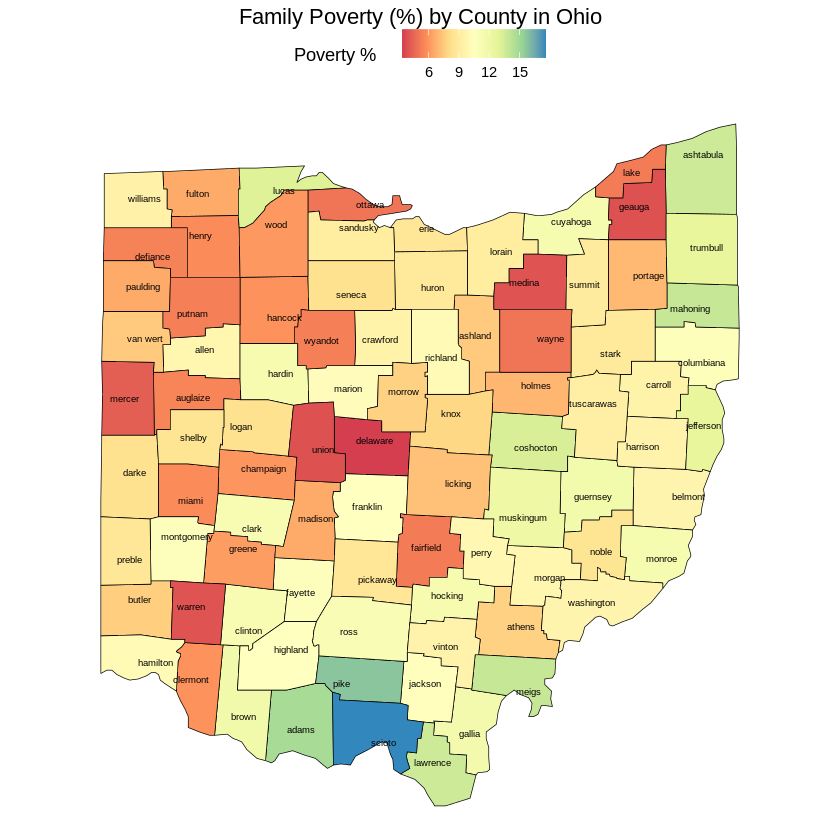

In [335]:
## 14. Draw the heat map for poverty

ggplot() +
geom_polygon(
data = map_df,
aes(x = long, y = lat, group = group, fill = poverty_pct),
color = "black",
linewidth = 0.2
) +
coord_fixed(1.3) +
geom_text(
data = centroids,
aes(x = clong, y = clat, label = county),
size = 2.0,
color = "black"
) +
scale_fill_distiller(palette = "Spectral", direction = 1) +
labs(
title = "Family Poverty (%) by County in Ohio",
fill = "Poverty %"
) +
theme_void() +
theme(
legend.position = "top",
plot.title = element_text(hjust = 0.5)
)

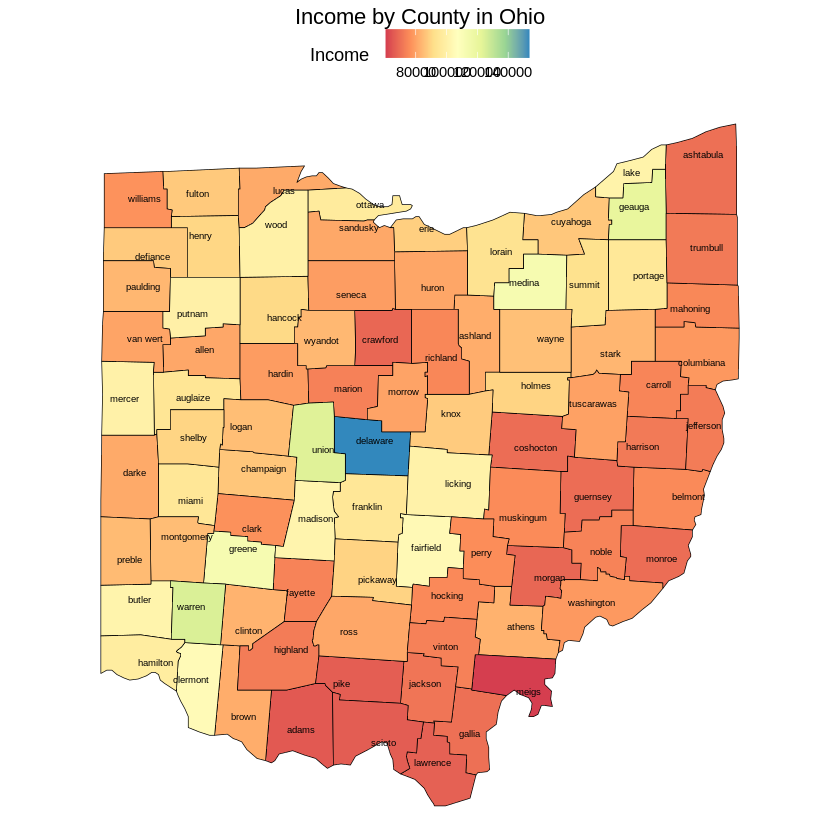

In [336]:
## 15. Draw the heat map for income

ggplot() +
  geom_polygon(
    data = map_df,
    aes(x = long, y = lat, group = group, fill = median_income),
    color = "black",
    linewidth = 0.2
  ) +
  coord_fixed(1.3) +
  geom_text(
    data = centroids,
    aes(x = clong, y = clat, label = county),
    size = 2.0,
    color = "black"
  ) +
  scale_fill_distiller(palette = "Spectral", direction = 1) +
  labs(
    title = "Income by County in Ohio",
    fill = "Income"
  ) +
  theme_void() +
  theme(
    legend.position = "top",
    plot.title = element_text(hjust = 0.5)
  )

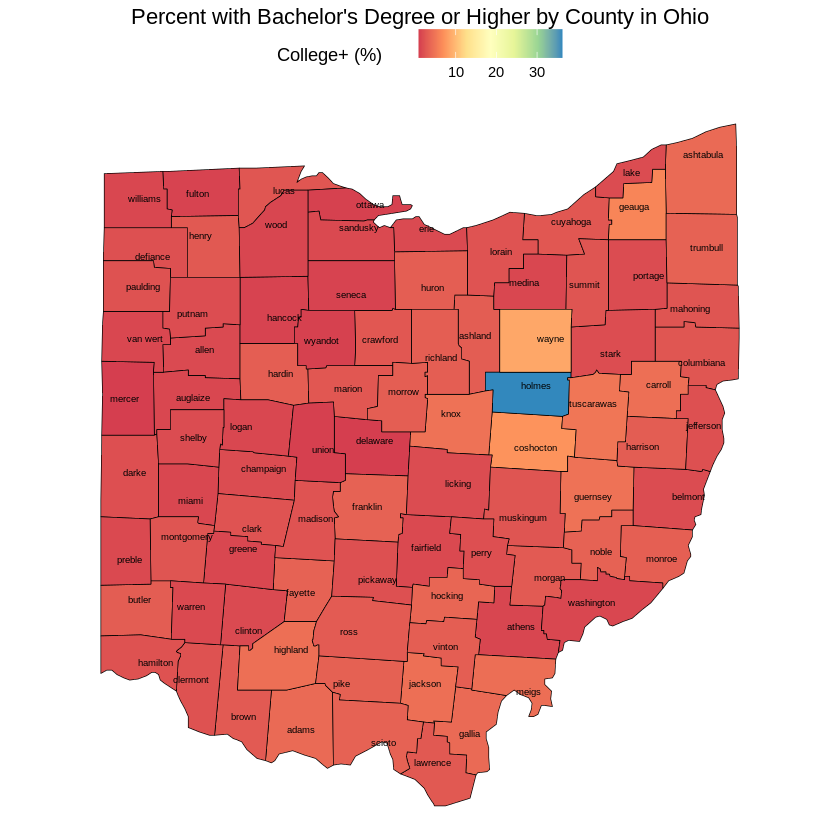

In [337]:
## 16. Draw the heat map for Education

ggplot() +
  geom_polygon(
    data = map_df,
    aes(x = long, y = lat, group = group, fill = college_plus_pct),
    color = "black",
    linewidth = 0.2
  ) +
  coord_fixed(1.3) +
  geom_text(
    data = centroids,
    aes(x = clong, y = clat, label = county),
    size = 2.0,
    color = "black"
  ) +
  scale_fill_distiller(palette = "Spectral", direction = 1) +
  labs(
    title = "Percent with Bachelor's Degree or Higher by County in Ohio",
    fill = "College+ (%)"
  ) +
  theme_void() +
  theme(
    legend.position = "top",
    plot.title = element_text(hjust = 0.5)
  )

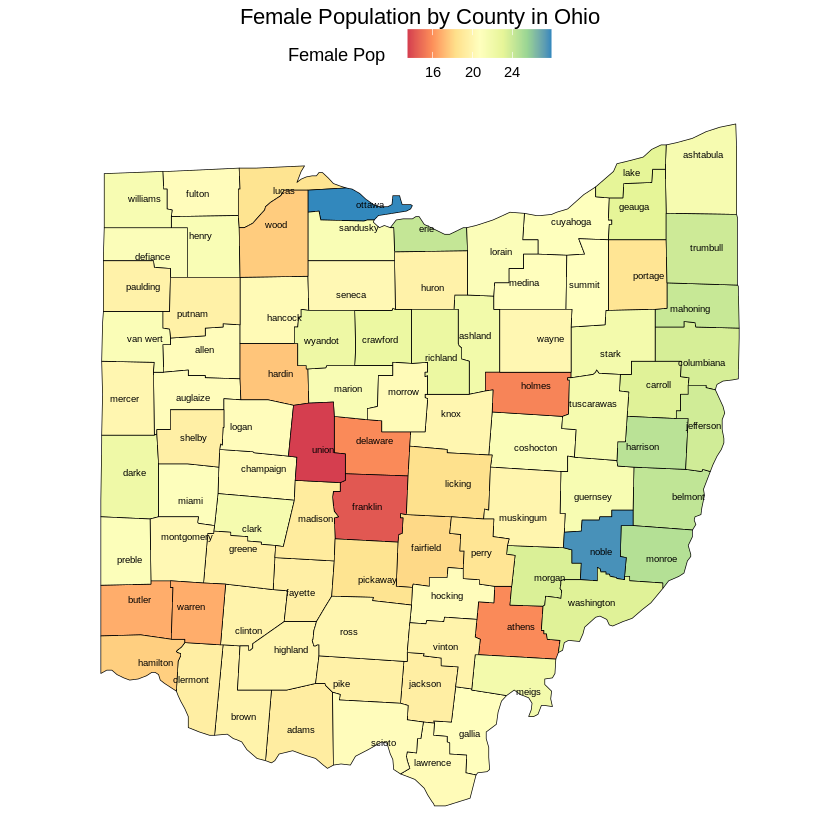

In [338]:
## 17. Draw the heat map for female population

ggplot() +
  geom_polygon(
    data = map_df,
    aes(x = long, y = lat, group = group, fill = female_pop),
    color = "black",
    linewidth = 0.2
  ) +
  coord_fixed(1.3) +
  geom_text(
    data = centroids,
    aes(x = clong, y = clat, label = county),
    size = 2.0,
    color = "black"
  ) +
  scale_fill_distiller(palette = "Spectral", direction = 1) +
  labs(
    title = "Female Population by County in Ohio",
    fill = "Female Pop"
  ) +
  theme_void() +
  theme(
    legend.position = "top",
    plot.title = element_text(hjust = 0.5)
  )

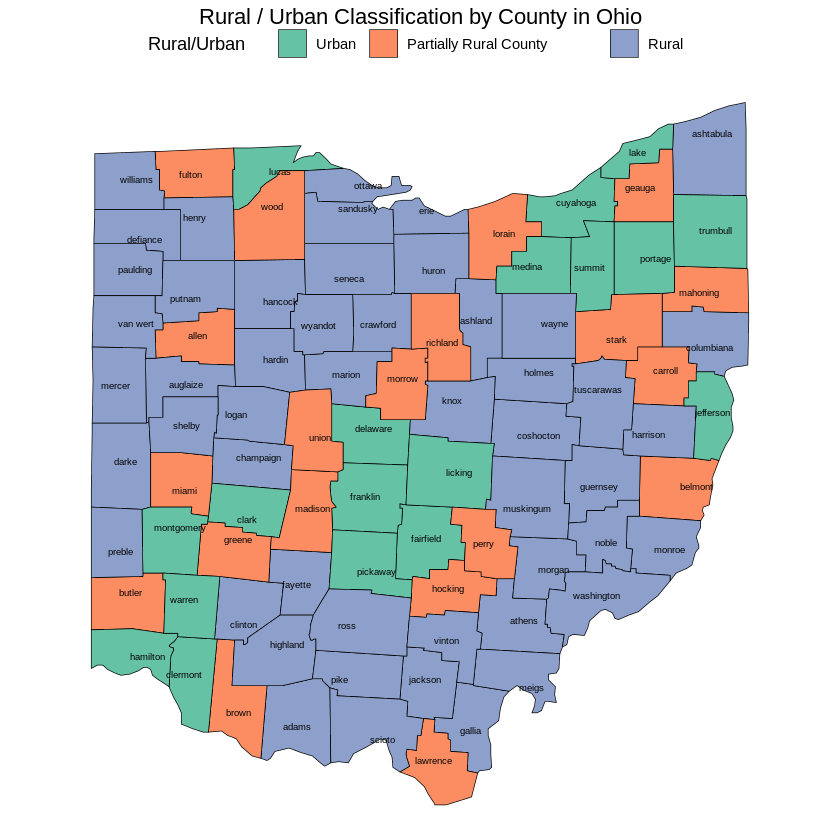

In [340]:
## 19. Draw the heat map for rural vs urban classification (categorical)

ggplot() +
  geom_polygon(
    data = map_df,
    aes(x = long, y = lat, group = group, fill = rural_urban),
    color = "black",
    linewidth = 0.2
  ) +
  coord_fixed(1.3) +
  geom_text(
    data = centroids,
    aes(x = clong, y = clat, label = county),
    size = 2.0,
    color = "black"
  ) +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title = "Rural / Urban Classification by County in Ohio",
    fill = "Rural/Urban"
  ) +
  theme_void() +
  theme(
    legend.position = "top",
    plot.title = element_text(hjust = 0.5)
  )

In [343]:
## 21. Logistic regression model

#high_incidence = 1 → higher-than-median cancer incidence
#high_incidence = 0 → lower-than-median cancer incidence
# Simple logistic regression
model1 <- glm(
  high_incidence ~ poverty_rate,
  data = full_df,
  family = binomial
)

summary(model1)

# Odds ratios
exp(coef(model1))

# 95% confidence intervals
exp(confint(model1))


Call:
glm(formula = high_incidence ~ poverty_rate, family = binomial, 
    data = full_df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)   0.65144    0.68620   0.949    0.342
poverty_rate -0.07276    0.07285  -0.999    0.318

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 121.99  on 87  degrees of freedom
Residual deviance: 120.98  on 86  degrees of freedom
AIC: 124.98

Number of Fisher Scoring iterations: 4


(Intercept) poverty_rate 
   1.9183003    0.9298281

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),0.5057953,7.631450
poverty_rate,0.8027286,1.070943


In [339]:
## 18. Draw the heat map for cancer incidence rate

ggplot() +
  geom_polygon(
    data = map_df,
    aes(x = long, y = lat, group = group, fill = cancer_incidence),
    color = "black",
    linewidth = 0.2
  ) +
  coord_fixed(1.3) +
  geom_text(
    data = centroids,
    aes(x = clong, y = clat, label = county),
    size = 2.0,
    color = "black"
  ) +
  scale_fill_distiller(palette = "Spectral", direction = 1) +
  labs(
    title = "Breast Cancer Incidence per 100,000 Women (Ohio)",
    fill = "Incidence"
  ) +
  theme_void() +
  theme(
    legend.position = "top",
    plot.title = element_text(hjust = 0.5)
  )

ERROR while rich displaying an object: Error in `geom_polygon()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'cancer_incidence' not found

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.nu

In [342]:
##22.
model_full <- glm(
  high_incidence ~ poverty_rate + median_income + college_plus_pct +
    female_pop + rural_urban + app_flag,
  data = full_df,
  family = binomial
)

summary(model_full)


Call:
glm(formula = high_incidence ~ poverty_rate + median_income + 
    college_plus_pct + female_pop + rural_urban + app_flag, family = binomial, 
    data = full_df)

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)  
(Intercept)                       -1.564e+01  7.045e+00  -2.220   0.0264 *
poverty_rate                       3.604e-01  1.712e-01   2.105   0.0353 *
median_income                      1.131e-04  4.497e-05   2.516   0.0119 *
college_plus_pct                  -1.325e-01  2.214e-01  -0.598   0.5497  
female_pop                         1.773e-01  1.303e-01   1.360   0.1737  
rural_urbanPartially Rural County -2.005e-01  8.079e-01  -0.248   0.8040  
rural_urbanRural                  -5.397e-01  7.838e-01  -0.689   0.4911  
app_flagAppalachian               -3.126e-01  6.944e-01  -0.450   0.6525  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null devia